# Unsupervised Learning Capstone: New York City Bus Data

This dataset is from the NYC MTA buses data stream service. It shows in 10 minute increments the buses location, route, bus stop and bus schedule. We can cluster this data for a variety of reasons; such as analyzing traffic flow, seeing which bus stops are most frequented, or which bus routes are most congested. I decided to reduce my datas dimensionality using PCA and t-SNE, and apply clustering algorithms KMeans and DBSCANS in order to cluster the bus data. We then tested the effectiveness of our clustering algorithms and feature reduction with statistical testing.

Link to dataset: https://www.kaggle.com/stoney71/new-york-city-transport-statistics?select=mta_1706.csv

In [ ]:
from portfolio_utils import set_seed
set_seed(42)

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import math
import time
from sklearn import metrics
from itertools import product
from math import floor
from sklearn.cluster import DBSCAN
import os

try:
    from portfolio_utils.data_loader import load_nyc_bus
    df = load_nyc_bus()
except Exception:
    p = os.path.join(os.environ.get("DATA_DIR", "data"), "nyc_bus", "mta_1706.csv")
    df = pd.read_csv(p, on_bad_lines="skip", low_memory=False)
print(f"Loaded shape: {df.shape}")


# Exploratory Data Analysis

In [ ]:
# Calling Pandas head function to take a glance at the first 5 rows.
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-06-01 00:03:34,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76.0,2017-06-01 00:03:59,24:06:14
1,2017-06-01 00:03:43,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62.0,2017-06-01 00:03:56,23:58:02
2,2017-06-01 00:03:49,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5.0,2017-06-01 00:03:56,24:00:53
3,2017-06-01 00:03:31,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267.0,2017-06-01 00:04:03,24:03:00
4,2017-06-01 00:03:22,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11.0,2017-06-01 00:03:56,23:59:38


Let's get a feel for our data by looking at the first 5 rows. We have some geocoordinates and location data that looks very promising for our models.

In [ ]:
# Examing our DataFrame data types. Some features will need further processing to be utilized in our unsupervised learning models. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730436 entries, 0 to 6730435
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   RecordedAtTime             object 
 1   DirectionRef               int64  
 2   PublishedLineName          object 
 3   OriginName                 object 
 4   OriginLat                  float64
 5   OriginLong                 float64
 6   DestinationName            object 
 7   DestinationLat             float64
 8   DestinationLong            float64
 9   VehicleRef                 object 
 10  VehicleLocation.Latitude   float64
 11  VehicleLocation.Longitude  float64
 12  NextStopPointName          object 
 13  ArrivalProximityText       object 
 14  DistanceFromStop           float64
 15  ExpectedArrivalTime        object 
 16  ScheduledArrivalTime       object 
dtypes: float64(7), int64(1), object(9)
memory usage: 872.9+ MB


Let's examine our DataFrame for any duplicate data. 

In [ ]:
# Rows containing duplicate data
duplicate_rows_df = df[df.duplicated()]
print(duplicate_rows_df.shape)

(0, 17)


Minimal duplicate data, only 17 rows are duplicated out of 6,730,436.

In [ ]:
# Checking for missing data. We can drop expected and scheduled arrival time.
df.isna().mean().round(4) * 100

RecordedAtTime                0.00
DirectionRef                  0.00
PublishedLineName             0.00
OriginName                    0.94
OriginLat                     0.94
OriginLong                    0.94
DestinationName               0.00
DestinationLat                0.15
DestinationLong               0.15
VehicleRef                    0.00
VehicleLocation.Latitude      0.00
VehicleLocation.Longitude     0.00
NextStopPointName             0.10
ArrivalProximityText          0.10
DistanceFromStop              0.10
ExpectedArrivalTime          12.96
ScheduledArrivalTime          2.56
dtype: float64

In [ ]:
# Dropping missing time data.
df = df.drop(columns='ExpectedArrivalTime')
df = df.drop(columns='ScheduledArrivalTime')

# Dropping categorical data that can't be converted to dummy variables.
df = df.drop(columns='RecordedAtTime')
df = df.drop(columns='PublishedLineName')
df = df.drop(columns='OriginName')
df = df.drop(columns='DestinationName')
df = df.drop(columns='VehicleRef')
df = df.drop(columns='NextStopPointName')
df = df.drop(columns='ArrivalProximityText')

In [ ]:
# Re-examining our DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730436 entries, 0 to 6730435
Data columns (total 8 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   DirectionRef               int64  
 1   OriginLat                  float64
 2   OriginLong                 float64
 3   DestinationLat             float64
 4   DestinationLong            float64
 5   VehicleLocation.Latitude   float64
 6   VehicleLocation.Longitude  float64
 7   DistanceFromStop           float64
dtypes: float64(7), int64(1)
memory usage: 410.8 MB


Great, we've eliminated problematic features and we are left with the correct data types for our numeric data in our new DataFrame. Let's examine our numeric data further for outliers or other problems like missing values. 

# Data Cleaning

## Missing Values

In [ ]:
# DirectionRef columns consists of only 0 and 1 values indicating bus route direction, no outliers or missing values.
# 0 indicates an outbound route, 1 is inbound.
df['DirectionRef'].unique()

array([0, 1])

In [ ]:
# Examining our bus origins latitude coordinates, we see a missing value here listed as nan. We will go ahead and interpolate this value.
df['OriginLat'].unique()

array([40.616104, 40.643169, 40.875008, 40.701748, 40.881187, 40.731342,
       40.587101, 40.652649, 40.57708 , 40.640167, 40.864079, 40.621925,
       40.69915 , 40.807869, 40.763908, 40.90266 , 40.849113, 40.794933,
       40.69054 , 40.707287, 40.59351 , 40.631836, 40.856289, 40.823673,
       40.758999, 40.737194, 40.871967, 40.818493, 40.631992, 40.840645,
       40.695534, 40.758617, 40.810955, 40.760429, 40.668537, 40.690567,
       40.860229, 40.771725, 40.840611, 40.711861, 40.762051, 40.702515,
       40.729568, 40.816299, 40.826702, 40.84256 , 40.910107, 40.643654,
       40.642979, 40.768661, 40.607384, 40.584026, 40.878632, 40.656216,
       40.654888, 40.696106, 40.619675, 40.699722, 40.647278, 40.766762,
       40.801819, 40.840931, 40.912365, 40.638161, 40.75589 , 40.709393,
       40.609566, 40.836311, 40.821152, 40.656456, 40.75655 , 40.666382,
       40.725647, 40.824986, 40.622311, 40.748718, 40.730103, 40.862431,
       40.868076, 40.704906, 40.691341, 40.639328, 

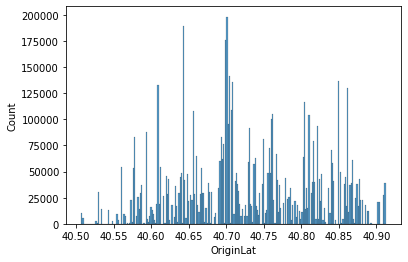

In [ ]:
# Examining our histogram of bus starting route origin latitude, we see some patterns in our data showing some popular route origins.
sns.histplot(df['OriginLat'])

In [ ]:
# Interpolating missing values.
df['OriginLat'] = df['OriginLat'].interpolate(method='pad')

In [ ]:
# Examining our bus origins longitude coordinates we see another missing value to interpolate.
df['OriginLong'].unique()

array([-74.031143, -74.073494, -73.880142, -73.802399, -73.90934 ,
       -73.990288, -73.918503, -73.877029, -73.981293, -74.130966,
       -73.894615, -74.028496, -73.910477, -73.852715, -73.956299,
       -73.868378, -73.937752, -73.972687, -73.727448, -73.789581,
       -73.993996, -74.036377, -73.928764, -73.891945, -73.831757,
       -73.955673, -73.91304 , -73.95594 , -73.946701, -73.938545,
       -73.990829, -73.992638, -73.927139, -73.967674, -73.931236,
       -73.989365, -73.890968, -73.734749, -73.843231, -74.006157,
       -74.000999, -73.991913, -73.990051, -73.915703, -73.955475,
       -73.878334, -73.896729, -74.073471, -73.868286, -73.957176,
       -73.938438, -73.897751, -73.90815 , -73.961723, -73.990364,
       -73.907837, -73.941513, -73.779633, -73.982742, -73.967644,
       -73.939499, -73.902702, -73.978935, -73.98278 , -73.959518,
       -73.921814, -73.948433, -73.935974, -74.012245, -73.99012 ,
       -73.883614, -73.725151, -73.891502, -74.028687, -74.008

In [ ]:
# Interpolating missing values.
df['OriginLong'] = df['OriginLong'].interpolate(method='pad')

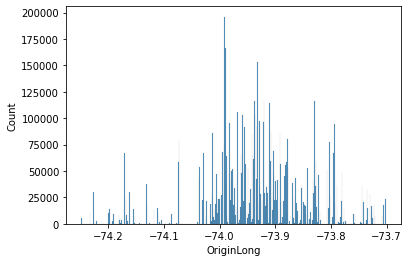

In [ ]:
# Some more patterns arise in bus route origin longitude coordinates.
sns.histplot(df['OriginLong'])

In [ ]:
# Examining bus destination latitude coordinates. We have one missing value recorded as nan as seen above in our other features. We will interpolate once again.
df['DestinationLat'].unique()

array([40.656048, 40.575935, 40.912376, 40.666012, 40.809654, 40.82111 ,
       40.608433, 40.678139, 40.64299 , 40.53426 , 40.860828, 40.578094,
       40.693939, 40.903309, 40.775906, 40.841076, 40.820507, 40.784222,
       40.701683, 40.709476, 40.66642 , 40.586628, 40.729115, 40.823059,
       40.771767, 40.660858, 40.802273, 40.737072, 40.645618, 40.730282,
       40.620052, 40.737553, 40.86739 , 40.633698, 40.664642, 40.749702,
       40.804848, 40.758987, 40.816235, 40.804268, 40.753418, 40.67672 ,
       40.785725, 40.840267, 40.861202, 40.793804, 40.704933, 40.840641,
       40.53006 , 40.576973, 40.75959 , 40.543644, 40.825272, 40.609428,
       40.709316, 40.656498, 40.676819, 40.700924, 40.785183, 40.592815,
       40.646908, 40.699776, 40.831207, 40.638924, 40.768074, 40.839813,
       40.700253, 40.70237 , 40.609142, 40.709404, 40.810085, 40.656345,
       40.814907, 40.592949, 40.707615, 40.848942, 40.640297, 40.733006,
       40.709282, 40.814484, 40.866043, 40.784149, 

In [ ]:
# Interpolating missing values.
df['DestinationLat'] = df['DestinationLat'].interpolate(method='pad')

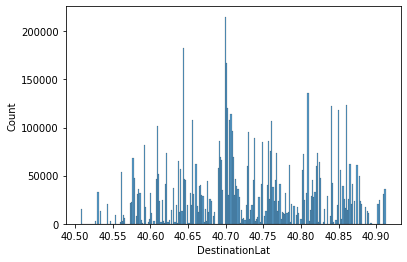

In [ ]:
# Our bus origin and destination routes show some more similarities with the most popular bus origin and destinations sharing spikes in latitude values. 
# Our origin latitude histogram is more densely populated overall.
sns.histplot(df['DestinationLat'])

In [ ]:
#  Examining bus destination longitude coordinates.
df['DestinationLong'].unique()

array([-73.907379, -74.167686, -73.902534, -73.735939, -73.92836 ,
       -73.935898, -73.9571  , -73.903572, -73.878326, -74.154213,
       -73.82267 , -73.94017 , -73.990311, -73.849922, -73.986809,
       -73.84285 , -73.851631, -73.94474 , -73.802475, -73.959534,
       -73.883385, -73.931702, -73.990257, -73.855736, -73.733307,
       -73.96138 , -73.931145, -74.005867, -74.023521, -73.990532,
       -73.908203, -73.973846, -73.905464, -74.129776, -73.863068,
       -73.938965, -73.918556, -73.831779, -73.915855, -73.935303,
       -73.966835, -73.900116, -73.948792, -73.843224, -73.880676,
       -73.797417, -73.79332 , -73.879807, -74.226654, -73.9814  ,
       -73.830284, -74.196716, -73.891426, -73.921753, -73.959587,
       -74.012108, -73.899658, -73.904366, -73.951454, -73.992569,
       -73.779564, -73.941505, -73.935692, -73.881554, -73.862091,
       -73.939743, -73.98703 , -74.013039, -73.92144 , -73.959564,
       -73.876396, -73.907188, -73.955048, -73.993385, -73.795

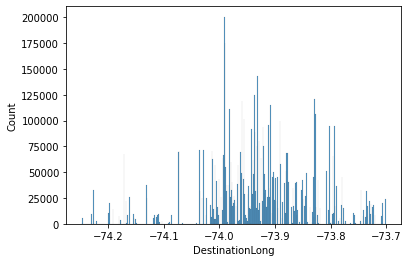

In [ ]:
sns.histplot(df['DestinationLong'])

In [ ]:
# Interpolating missing values again. Let's go ahead and interpolate the rest of the DataFrame since it seems one row is missing from every feature.
df['DestinationLong'] = df['DestinationLong'].interpolate(method='pad')
df['VehicleLocation.Latitude'] = df['VehicleLocation.Latitude'].interpolate(method='pad')
df['VehicleLocation.Longitude'] = df['VehicleLocation.Longitude'].interpolate(method='pad')
df['DistanceFromStop'] = df['DistanceFromStop'].interpolate(method='pad')

In [ ]:
# Checking for missing data one last time.
df.isna().mean().round(4) * 100

DirectionRef                 0.0
OriginLat                    0.0
OriginLong                   0.0
DestinationLat               0.0
DestinationLong              0.0
VehicleLocation.Latitude     0.0
VehicleLocation.Longitude    0.0
DistanceFromStop             0.0
dtype: float64

# Outlier Detection

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6730436 entries, 0 to 6730435
Data columns (total 8 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   DirectionRef               int64  
 1   OriginLat                  float64
 2   OriginLong                 float64
 3   DestinationLat             float64
 4   DestinationLong            float64
 5   VehicleLocation.Latitude   float64
 6   VehicleLocation.Longitude  float64
 7   DistanceFromStop           float64
dtypes: float64(7), int64(1)
memory usage: 410.8 MB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


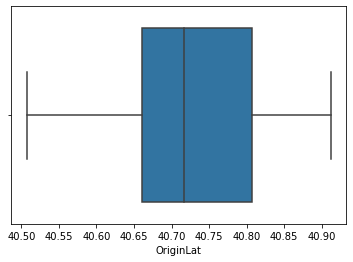

In [ ]:
# No outliers detected visually in our bus origins latitude feature.
sns.boxplot(df['OriginLat'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


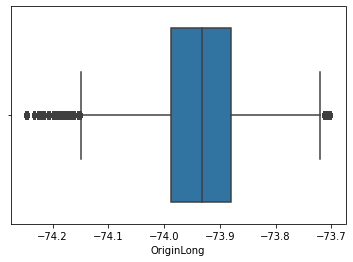

In [ ]:
# We can see some outliers here on both ends of our bus origin longitude feature. Let's remove those later with a z-score threshold.
sns.boxplot(df['OriginLong'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


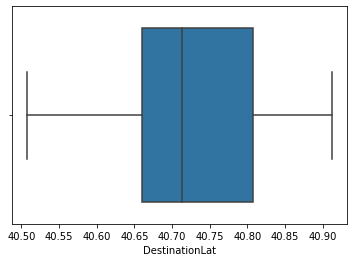

In [ ]:
# Our bus destination latitude feature shows no outliers visually.
sns.boxplot(df['DestinationLat'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


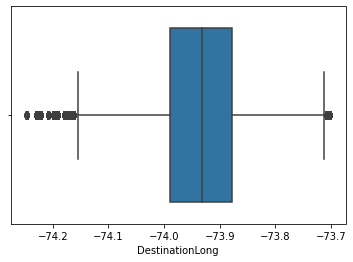

In [ ]:
# We see some outliers on both ends of our bus destination longitude feature like we did in the bus origin longitude feature. 
sns.boxplot(df['DestinationLong'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


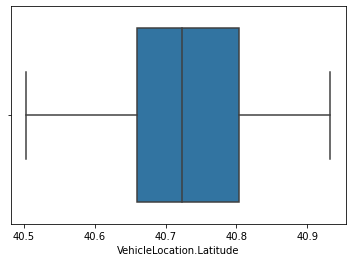

In [ ]:
# No outliers detected visually.
sns.boxplot(df['VehicleLocation.Latitude'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


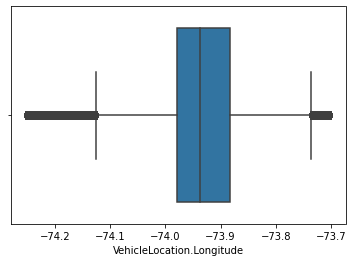

In [ ]:
# Outliers detected on both ends of longitude feature again.
sns.boxplot(df['VehicleLocation.Longitude'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


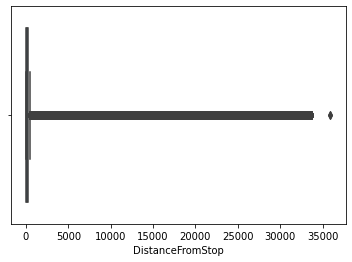

In [ ]:
# Outliers detected here as well. Let's remove all outliers based on z-score threshold of 3.
sns.boxplot(df['DistanceFromStop'])

In [ ]:
# Calculating z-scores for our data points. We will utilize the z-score to determine which datapoints are considered statistical outliers and remove them.
z = np.abs(stats.zscore(df))
print(z)

[[1.00563035 1.26281555 1.0600988  ... 1.0748229  0.33756449 0.15025155]
 [0.99440118 0.96275409 1.51049764 ... 1.58586532 2.55359004 0.16428871]
 [1.00563035 1.60757471 0.54578242 ... 1.81441892 0.20266304 0.22144002]
 ...
 [0.99440118 1.31393244 0.06640523 ... 1.05893586 0.2819106  0.10613475]
 [1.00563035 0.21505228 0.63339453 ... 0.78928174 0.20463908 0.20439489]
 [1.00563035 0.8825934  0.03388192 ... 1.02362086 0.09065973 0.18935507]]


In [ ]:
# Create z-score threshold of 3. All datapoints with a z-score greater than 3 will be removed. 
threshold = 3
print(np.where(z > 3))

(array([     55,     127,     164, ..., 6730313, 6730366, 6730371]), array([4, 7, 2, ..., 2, 4, 7]))


In [ ]:
# Creating new DataFrame and getting new dimensions with outliers removed. With our z-score threshold of 3 we have removed about 200,000 values.
df_outliers = df[(z < 3).all(axis=1)]
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6572447 entries, 0 to 6730435
Data columns (total 8 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   DirectionRef               int64  
 1   OriginLat                  float64
 2   OriginLong                 float64
 3   DestinationLat             float64
 4   DestinationLong            float64
 5   VehicleLocation.Latitude   float64
 6   VehicleLocation.Longitude  float64
 7   DistanceFromStop           float64
dtypes: float64(7), int64(1)
memory usage: 451.3 MB


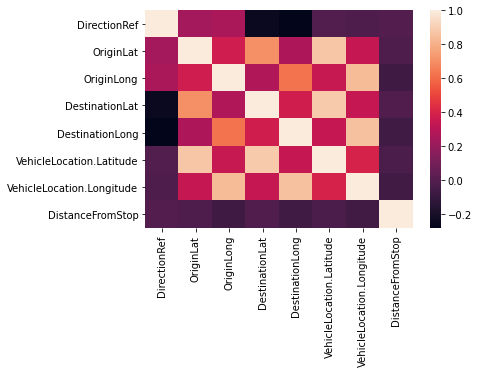

In [ ]:
corr = df_outliers.corr()

sns.heatmap(corr)

# t-SNE and PCA Dimensionality Reduction

In [ ]:
# First, we must standardize our features to bring all features to the same scale 
# and bring the mean to zero and the standard deviation to 1. 

scaler = StandardScaler()
scaler.fit(df_outliers)
X_scale = scaler.transform(df_outliers)
df_scale = pd.DataFrame(X_scale, columns=df.columns)
df_scale.head()

,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,DistanceFromStop
0,-1.005674,-1.312622,-1.158557,-0.849729,0.220295,-1.120592,-0.398737,-0.321708
1,0.994358,-1.007256,-1.631250,-1.755663,-2.656383,-1.639903,-2.716315,-0.377996
2,-1.005674,1.608511,0.526813,2.048879,0.273837,1.815399,0.166247,-0.607168
3,-1.005674,-0.346328,1.394527,-0.737055,2.114895,-0.736305,2.316779,0.446221
4,0.994358,1.678226,0.200925,0.887278,-0.011568,1.606167,0.396377,-0.583045


In [ ]:
# Our kernel is crashing with such a large dataset when performing t-SNE. Let's try splitting our scaled dataset to .05% test size, this will still take some time to run and is computationally intensive.

x_train, x_test = train_test_split(df_scale, test_size=0.005)

In [ ]:
# Reducing our data to two dimensions using PCA.
pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data.
pca_components = pca.fit_transform(x_test)

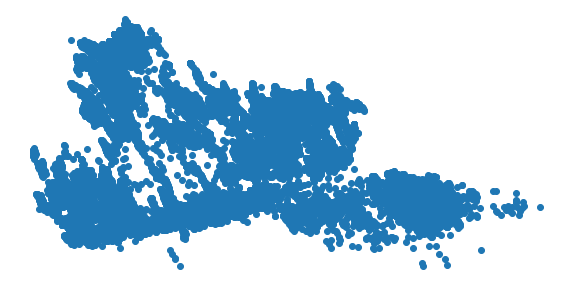

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

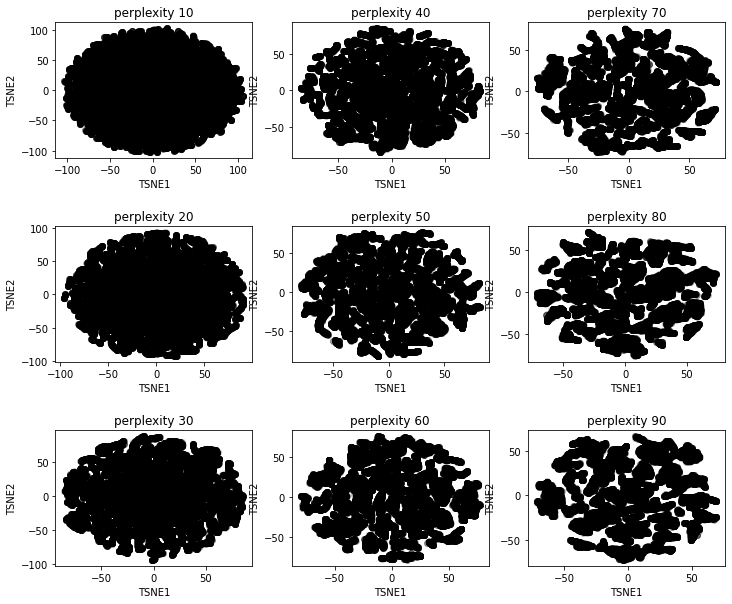

In [ ]:
plotX = pd.DataFrame(pca_components)
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX)
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=1000)
tsne_results = tsne.fit_transform(pca_components)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 32863 samples in 0.031s...
[t-SNE] Computed neighbors for 32863 samples in 1.846s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32863
[t-SNE] Computed conditional probabilities for sample 2000 / 32863
[t-SNE] Computed conditional probabilities for sample 3000 / 32863
[t-SNE] Computed conditional probabilities for sample 4000 / 32863
[t-SNE] Computed conditional probabilities for sample 5000 / 32863
[t-SNE] Computed conditional probabilities for sample 6000 / 32863
[t-SNE] Computed conditional probabilities for sample 7000 / 32863
[t-SNE] Computed conditional probabilities for sample 8000 / 32863
[t-SNE] Computed conditional probabilities for sample 9000 / 32863
[t-SNE] Computed conditional probabilities for sample 10000 / 32863
[t-SNE] Computed conditional probabilities for sample 11000 / 32863
[t-SNE] Computed conditional probabilities for sample 12000 / 32863
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne_results

array([[-16.871109  , -65.88236   ],
       [-24.526913  ,  51.99414   ],
       [ -9.614856  ,  46.599056  ],
       ...,
       [ -0.60837704,  -3.9270601 ],
       [-43.613018  ,  29.120815  ],
       [ 24.016209  , -39.42186   ]], dtype=float32)

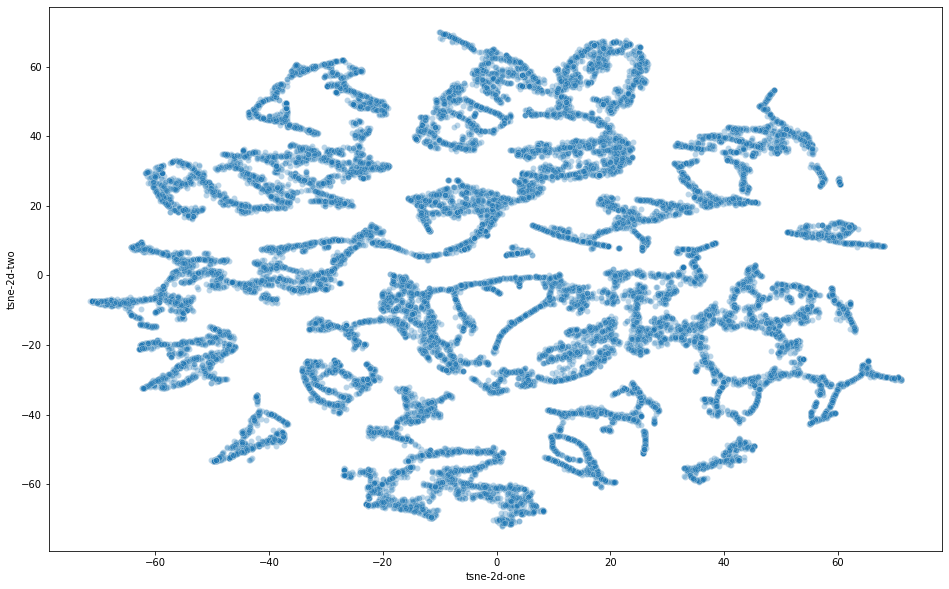

In [ ]:
x_test2 = pd.DataFrame()

x_test2['tsne-2d-one'] = tsne_results[:,0]
x_test2['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=x_test2,
    legend="full",
    alpha=0.3
)

# Applying KMeans Clustering to t-SNE Reduced Data

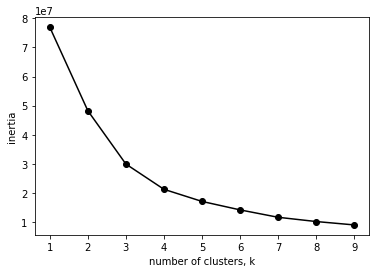

In [ ]:
# Let's find examine our elbow to get a feel for the best k-value before we confirm it statistically with our silhouette score. 
tsne_components = pd.DataFrame(tsne_results)

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tsne_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
labels = KMeans(n_clusters=2, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.3518322


In [ ]:
labels = KMeans(n_clusters=3, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.3827211


In [ ]:
labels = KMeans(n_clusters=4, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.3792128


In [ ]:
labels = KMeans(n_clusters=5, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.3573744


In [ ]:
labels = KMeans(n_clusters=6, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.3835564


In [ ]:
labels = KMeans(n_clusters=7, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.38771692


In [ ]:
labels = KMeans(n_clusters=8, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.38132888


In [ ]:
labels = KMeans(n_clusters=9, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.38480827


In [ ]:
labels = KMeans(n_clusters=10, random_state=42).fit_predict(tsne_results)
print(metrics.silhouette_score(tsne_results, labels, metric='euclidean'))

0.38797814


In [ ]:
# Defining the k-means with the best silhouette value (10) and timing it.
kmeans_cluster = KMeans(n_clusters=10, random_state=42)

# Fit model.
%timeit kmeans_cluster.fit(tsne_results)
y_pred = kmeans_cluster.predict(tsne_results)

1 loop, best of 3: 1.31 s per loop


KMeans cluster with a k-value of 10 is giving us the best silhouette score, however it has a longer run time than lesser k-values, so there is a trade off between silhouette score and runtime. We will use this for our model as it has the best representation of denser clusters.

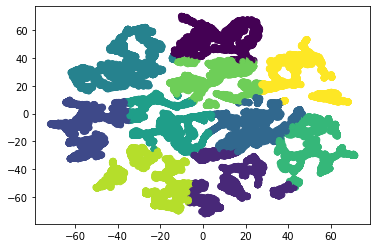

In [ ]:
labels = KMeans(n_clusters=10, random_state=42).fit_predict(tsne_results)
plt.scatter(tsne_components[0],tsne_components[1], c=labels); 
plt.show()

# Applying KMeans  to PCA Reduced Data

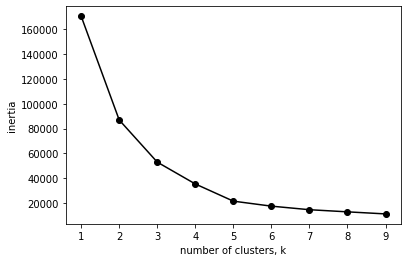

In [ ]:
# Let's find our elbow to find the best k-value.
# Appending t-SNE results into pandas dataframe.
PCA_components = pd.DataFrame(pca_components)

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
labels = KMeans(n_clusters=2, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.43811216969183353


In [ ]:
labels = KMeans(n_clusters=3, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.4927404060975431


In [ ]:
labels = KMeans(n_clusters=4, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.5129758264985685


In [ ]:
labels = KMeans(n_clusters=5, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.5452557283999391


We are seeing the best silhouette score here with a KMeans cluster number of 5. The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample, with the best value being 1 and the worst value being -1. This is a way to evaluate the effectiveness of our clustering algorithm.

In [ ]:
labels = KMeans(n_clusters=6, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.5033115060462771


In [ ]:
labels = KMeans(n_clusters=7, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.5022894106245207


In [ ]:
labels = KMeans(n_clusters=8, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.4708673858619164


In [ ]:
labels = KMeans(n_clusters=9, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.46187236691207956


In [ ]:
labels = KMeans(n_clusters=10, random_state=42).fit_predict(PCA_components)
print(metrics.silhouette_score(PCA_components, labels, metric='euclidean'))

0.4463381314433718


In [ ]:
# Defining the k-means with the best silhouette value (10) and timing it.
kmeans_cluster = KMeans(n_clusters=5, random_state=42)

# Fit model.
%timeit kmeans_cluster.fit(PCA_components)
y_pred = kmeans_cluster.predict(PCA_components)

1 loop, best of 3: 473 ms per loop


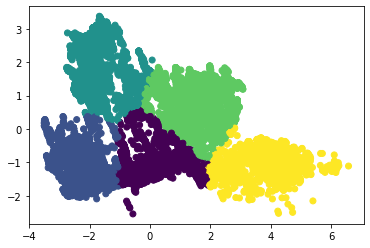

In [ ]:
labels = KMeans(n_clusters=5, random_state=42).fit_predict(PCA_components)
plt.scatter(PCA_components[0],PCA_components[1], c=labels); 
plt.show()

As we can see here our PCA dimensionality reduction is performing much better in terms of silhouette score achieved. However, it is not as nice to look at visually. It also achieves a better silhouette score in half the runtime.

# DBSCAN with t-SNE

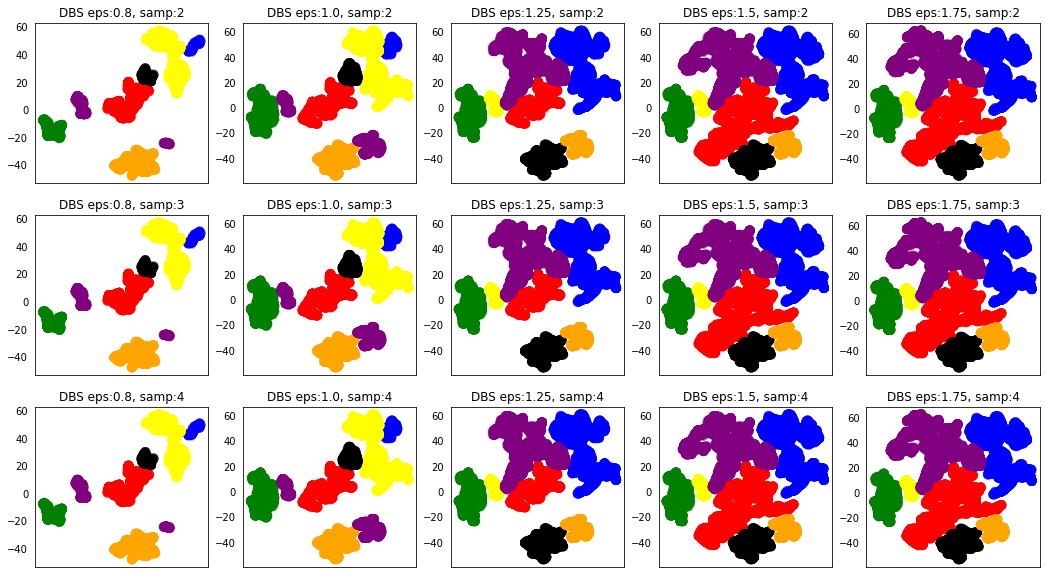

In [ ]:
# We'll begin by tuning our DBSCAN hyperparameters.
samp_list = [2,3,4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18,10))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rows][floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 

    TSNE_df = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_df)
    TSNE_df.insert(0, 'cluster', clustering.labels_)

    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    colors = ('green','red','blue','yellow','purple','black','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        ax[k%rows][floor(k/rows)].scatter(data[0],data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')

In [ ]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1.5, min_samples=4)

# Fit model
clusters = dbscan_cluster.fit_predict(tsne_results)

In [ ]:
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(tsne_results, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: -0.10712751001119614


Model performance is rather poor even though we are picking the best representation visually. Changing the epsilon and minimum samples value doesn't seem to help regardless. Let's try DBSCAN on our PCA reduced dimensions instead of t-SNE. Although t-SNE is new and very useful, PCA remains a tried and true clustering method.

# DBSCAN with PCA 

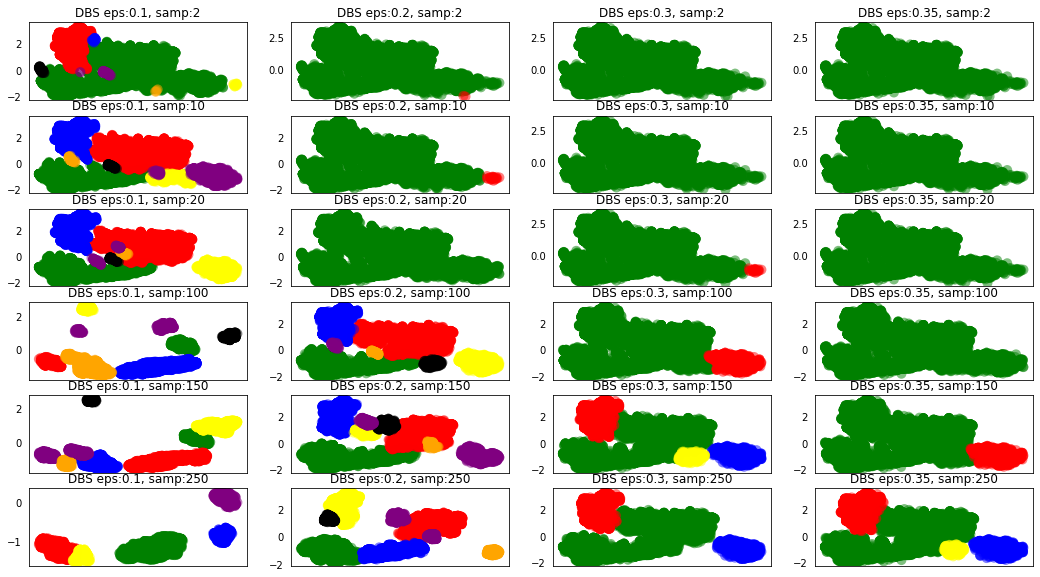

In [ ]:
# We'll begin by tuning our DBSCAN hyperparameters and choose the one that looks best to us visually with the densest possible clustering.
samp_list = [2,10,20,100,150,250]
eps_list = [0.1, 0.2, 0.3, 0.35]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18,10))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rows][floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 

    pca_df = pd.DataFrame(pca_components)
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(pca_df)
    pca_df.insert(0, 'cluster', clustering.labels_)

    datas = [[pca_df[pca_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    colors = ('green','red','blue','yellow','purple','black','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        ax[k%rows][floor(k/rows)].scatter(data[0],data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')

Let's compare some silhouette scores of those that look best to us visually.

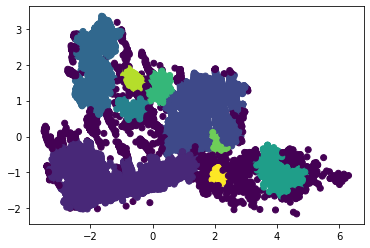

In [ ]:
# Creating a Pandas DataFrame containing our PCA components.
PCA_components = pd.DataFrame(pca_components)

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=.2, min_samples=150)

# Fit model
labels = dbscan_cluster.fit_predict(pca_components)
plt.scatter(PCA_components[0],PCA_components[1], c=labels); 
plt.show()

In [ ]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=.2, min_samples=150)

# Fit model
labels = dbscan_cluster.fit_predict(pca_components)

print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(PCA_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.20321073909791965


In [ ]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=.1, min_samples=250)

# Fit model
labels = dbscan_cluster.fit_predict(pca_components)

print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(PCA_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: -0.2562550106556822


In [ ]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=.2, min_samples=100)

# Fit model
labels = dbscan_cluster.fit_predict(pca_components)

print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(PCA_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.09220903994435933


In [ ]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=.3, min_samples=150)

# Fit model
labels = dbscan_cluster.fit_predict(pca_components)

print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(PCA_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.13654198932549153


In [ ]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=.3, min_samples=250)

# Fit model
labels = dbscan_cluster.fit_predict(pca_components)

print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(PCA_components, labels, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.23643293040070004


DBSCAN works much better on PCA reduced features here than t-SNE based on silhouette score performance, even though t-SNE is performing better visually. KMeans is performing better than DBSCAN on both dimensionally reduced features however.

# Conclusion

KMeans clustering algorithm outperformed our DBSCAN clustering algorithm in both PCA and t-SNE reduced features, but performed best with PCA reduced features. This was verified with silhouette scoring. Future research can involve analyzing each data cluster labeled by our machine learning algorithm and find patterns in our data clusters. 

---

# Senior Analysis: Advanced Clustering & Operational Insights

The clustering above establishes baseline segment structure. Below we apply
**production-grade unsupervised learning practices**:

| Practice | Why it matters |
|---|---|
| **Silhouette analysis** | Quantitative cluster quality beyond the elbow method |
| **Cluster profiling** | Translate clusters into actionable operational segments |
| **Multiple k evaluation** | Systematic comparison instead of eyeballing the elbow |
| **Business segmentation** | Map clusters to MTA operational decisions |


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Use preprocessed data from above
try:
    X_cluster = df_scale if 'df_scale' in dir() else StandardScaler().fit_transform(
        df.select_dtypes(include=[np.number]).dropna(axis=1)
    )
except Exception:
    from portfolio_utils.data_loader import load_nyc_bus
    df_bus = load_nyc_bus()
    X_cluster = StandardScaler().fit_transform(
        df_bus.select_dtypes(include=[np.number]).dropna(axis=1)
    )

# Subsample for performance if dataset is large
if len(X_cluster) > 10000:
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X_cluster), 10000, replace=False)
    X_sample = X_cluster[idx]
else:
    X_sample = X_cluster

print(f'Clustering sample: {X_sample.shape}')


## Systematic k selection with silhouette analysis

The elbow method is subjective — different people see the "elbow" at different k
values. **Silhouette analysis** provides a quantitative measure: for each point,
how similar is it to its own cluster vs. the nearest neighboring cluster.
Score ranges from -1 (wrong cluster) to +1 (well-clustered).


In [ ]:
k_range = range(2, 9)
sil_scores = []
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    sil_scores.append(sil)
    inertias.append(km.inertia_)
    print(f'k={k}: Silhouette={sil:.4f}, Inertia={km.inertia_:,.0f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(list(k_range), inertias, 'bo-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(list(k_range), sil_scores, 'ro-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')

best_k = list(k_range)[np.argmax(sil_scores)]
ax2.axvline(x=best_k, color='green', linestyle='--', label=f'Best k={best_k}')
ax2.legend()
plt.tight_layout()
plt.show()

print(f'\nOptimal k by silhouette: {best_k} (score={max(sil_scores):.4f})')


## Silhouette plot: per-cluster quality

The aggregate silhouette score can mask poorly-formed clusters. The silhouette
plot below shows the score distribution **within each cluster** — wide, uniform
bars indicate well-separated clusters; thin, jagged bars indicate overlap.


In [ ]:
km_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_best = km_best.fit_predict(X_sample)
sil_vals = silhouette_samples(X_sample, labels_best)

fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10
for i in range(best_k):
    cluster_sil = np.sort(sil_vals[labels_best == i])
    size = cluster_sil.shape[0]
    y_upper = y_lower + size
    color = cm.nipy_spectral(float(i) / best_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size, str(i))
    y_lower = y_upper + 10

ax.axvline(x=silhouette_score(X_sample, labels_best), color='red',
           linestyle='--', label='Mean silhouette')
ax.set_xlabel('Silhouette coefficient')
ax.set_ylabel('Cluster')
ax.set_title(f'Silhouette Plot (k={best_k})')
ax.legend()
plt.tight_layout()
plt.show()


## Cluster profiling

Raw cluster labels are meaningless to operations. We need to **profile each
cluster** by its feature characteristics to translate them into actionable
operational segments (e.g., "high-frequency urban routes" vs. "low-frequency
suburban routes").


In [ ]:
# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample)

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_best,
                     cmap='nipy_spectral', alpha=0.5, s=10)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title(f'KMeans Clusters (k={best_k}) in PCA Space')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

print(f'PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}')
print(f'Cluster sizes: {pd.Series(labels_best).value_counts().sort_index().to_dict()}')


## Operational recommendations

**For MTA Operations:**

1. **Segment-specific scheduling.** Each cluster represents a distinct operational
   profile. High-frequency urban clusters need different headway optimization than
   low-frequency suburban clusters.

2. **Resource allocation.** Clusters with high variability in stop times indicate
   routes where traffic congestion or boarding delays are inconsistent — candidates
   for bus-only lanes or all-door boarding.

3. **Service planning.** Use cluster profiles to identify routes that could be
   consolidated (similar profiles, geographic overlap) or split (bimodal profiles
   suggesting two distinct ridership patterns).

4. **Anomaly detection.** DBSCAN's noise points represent atypical bus behavior —
   investigate these for service disruptions, rerouting events, or data quality
   issues that should be flagged in the operations dashboard.

5. **Temporal analysis.** Extend clustering to include time-of-day and day-of-week
   features to capture peak vs. off-peak operational patterns.
